In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

In [53]:

def get_meteo_weather_history(lat, lon, start_date, end_date):

    # API endpoint and parameters
    url = "https://archive-api.open-meteo.com/v1/archive"
    params = {
        "latitude": latitude,
        "longitude": longitude,
        "start_date": start_date,
        "end_date": end_date,
        "daily": ["temperature_2m_max", "temperature_2m_min", "precipitation_sum"],
        "timezone": "America/Los_Angeles"
    }

    # Make the request
    response = requests.get(url, params=params)
    data = response.json()

    # Convert to DataFrame
    weather_df = pd.DataFrame({
        "date": data["daily"]["time"],
        "temp_max": data["daily"]["temperature_2m_max"],
        "temp_min": data["daily"]["temperature_2m_min"],
        "precipitation": data["daily"]["precipitation_sum"]
    })

    # Convert date to datetime object
    weather_df["date"] = pd.to_datetime(weather_df["date"])


    return weather_df


Get the weather for Fort Mason Equator Coffe (don't do this over and over - this uses a free open source api which asks its users to respect the usage)
Save it to a CSV
Turns out we only need to do Fort Mason as the other two coffee shops are close by

In [54]:
# Date range (based on your dataset)
start_date = "2019-01-01"
end_date = "2024-12-31"

# Fort Mason - Equator Coffee lat lon
fortMasonLatitude = 37.805424841127625
fortMasonLongitude = -122.43189815767089
# only run this if we lose our data and need to pull it again (uses a free api)
if (False):
    weather_df = get_meteo_weather_history(fortMasonLatitude, fortMasonLongitude, start_date, end_date)
    # Save to CSV
    weather_df.to_csv("C:\\Dev\\School\\SFU\\Courses\\Bus774-AIforBusiness\\GroupProject\\Group4data\\san_fran_open_meteo_weather.csv", index=False)
else:
    #weather_df = pd.read_csv("C:\\Dev\\School\\SFU\\Courses\\Bus774-AIforBusiness\\GroupProject\\Group4data\\san_fran_open_meteo_weather.csv")
    weatherURL = "https://www.dropbox.com/scl/fi/khb765ddg0qox6iy8qtkb/sanfran_weather.csv?rlkey=yccip6qd8kcx0jqz80jocddqf&dl=1"
    weather_data = pd.read_csv(weatherURL)


# Preview
print(weather_data.head())


# # Lake Merrit - Equator Coffee lat lon  - DON'T BOTHER - LAT LON IS NEARLY THE SAME AS FORT MASON
# lakeMerritLatitude = 37.81242756270673
# lakeMerritongitude = -122.26105919815194
# weather_df = get_meteo_weather_history(lakeMerritLatitude, lakeMerritongitude, start_date, end_date)
# # Save to CSV
# weather_df.to_csv("C:\\Dev\\School\\SFU\\Courses\\Bus774-AIforBusiness\\GroupProject\\Group4data\\lake_merrit_open_meteo_weather.csv", index=False)


         date  temp_max  temp_min  precipitation
0  2019-01-01      12.1       4.2            0.0
1  2019-01-02      11.6       4.5            0.0
2  2019-01-03      10.9       4.6            0.0
3  2019-01-04      12.0       4.9            0.0
4  2019-01-05      12.7       9.4            5.8


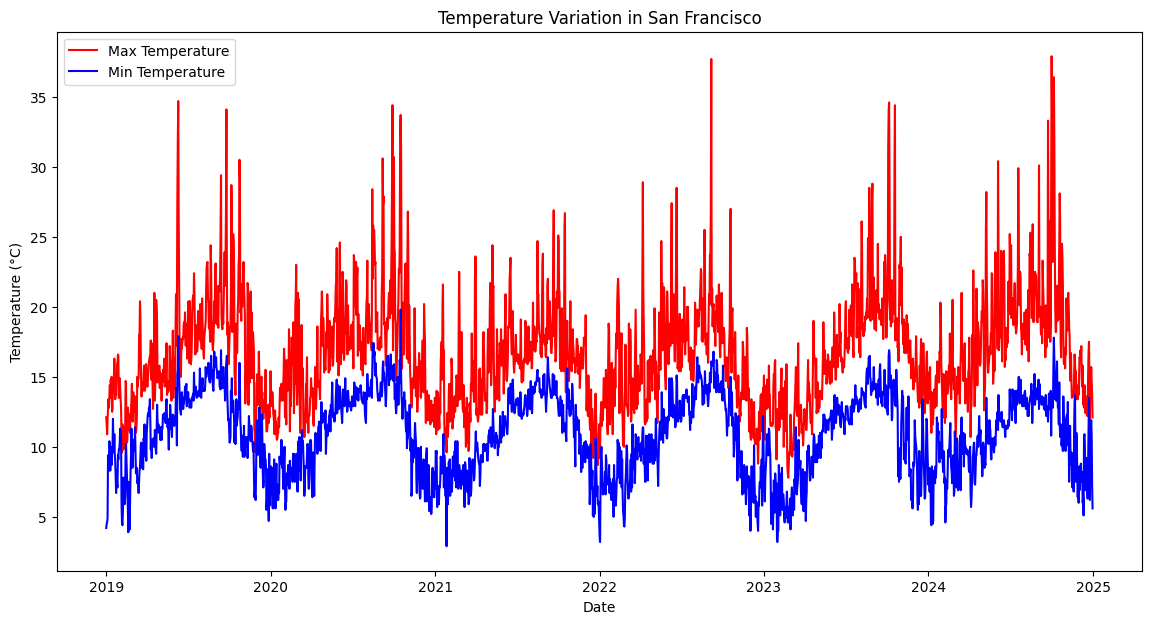

In [73]:
# Convert 'DOB' to datetime
weather_data['date'] = pd.to_datetime(weather_data['date'])

# Graph the weather data
plt.figure(figsize=(14, 7)) 
plt.plot(weather_data['date'], weather_data['temp_max'], label='Max Temperature', color='red')
plt.plot(weather_data['date'], weather_data['temp_min'], label='Min Temperature', color='blue')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.title('Temperature Variation in San Francisco')
plt.legend()
plt.show()


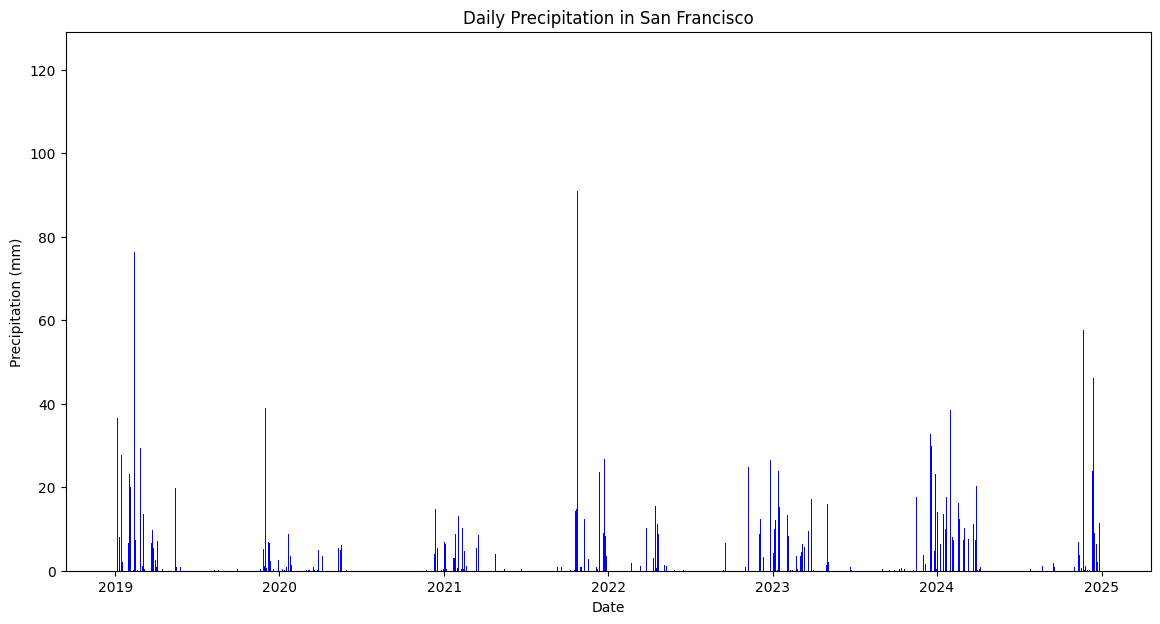

In [74]:
plt.figure(figsize=(14, 7))
plt.bar(weather_data['date'], weather_data['precipitation'], color='blue')
plt.xlabel('Date')
plt.ylabel('Precipitation (mm)')
plt.title('Daily Precipitation in San Francisco')
plt.show()

Next let's get our sales data for the 3 stores

Start with Fort Mason

In [57]:
fortMason5ySalesURL = "https://www.dropbox.com/scl/fi/c73v6ce9ij7rupc74quyz/FortMason5yrNetSalesbyDay.csv?rlkey=lnt0t56erqvea18fh052komur&dl=1"
fortMason5y_data = pd.read_csv(fortMason5ySalesURL)
# Preview
print(fortMason5y_data.head())



   LOCATION ID LOCATION NAME       DOB DAY OF WEEK              MSD  \
0            6    Fort Mason  1/1/2019     Tuesday  COFFEE & NA BEV   
1            6    Fort Mason  1/1/2019     Tuesday             FOOD   
2            6    Fort Mason  1/1/2019     Tuesday             FOOD   
3            6    Fort Mason  1/1/2019     Tuesday  COFFEE & NA BEV   
4            6    Fort Mason  1/1/2019     Tuesday           RETAIL   

                       SD   AMOUNT  COMP AMOUNT  PROMO AMOUNT  
0    Retail Coffee Drinks  1908.65        17.75             0  
1      Baked Goods-Pantry   199.75         0.00             0  
2  Retail Packaged-Pantry   178.00         0.00             0  
3         Other Beverages   163.50         0.00             0  
4           Retail Coffee   119.50         0.00             0  


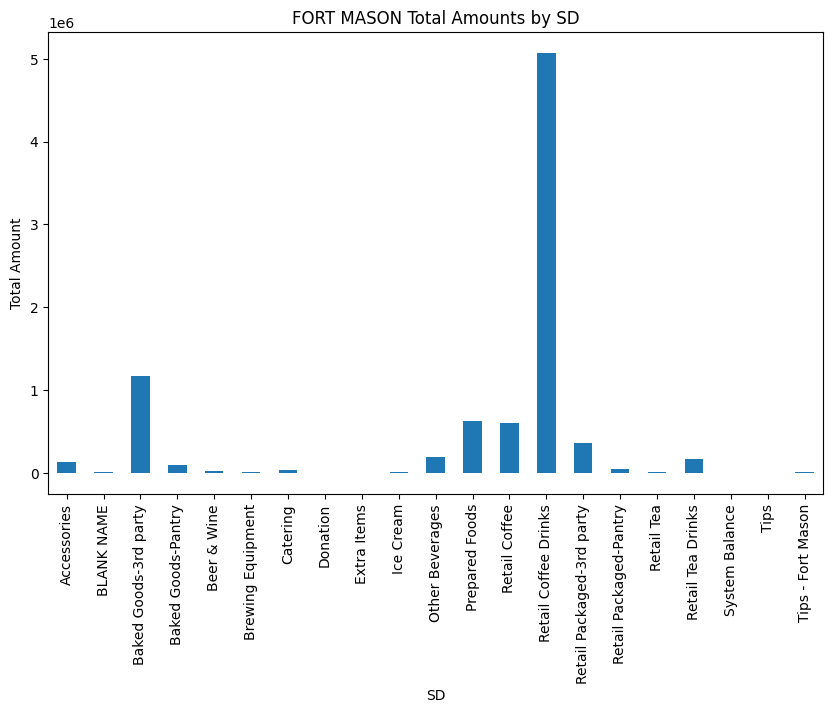

In [58]:

# Group the data by 'SD' and sum the 'AMOUNT'
fm_grouped_data = fortMason5y_data.groupby('SD')['AMOUNT'].sum()

# Plot the data
plt.figure(figsize=(10, 6))
fm_grouped_data.plot(kind='bar')
plt.title('FORT MASON Total Amounts by SD')
plt.xlabel('SD')
plt.ylabel('Total Amount')
plt.show()

In [59]:
blank_name_indices = fortMason5y_data[fortMason5y_data['SD'] == 'BLANK NAME'].index
print(blank_name_indices)

Index([ 4895,  4907,  4920,  4935,  4945,  4958,  4970,  4982,  4993,  5007,
        5030,  5038,  5052,  5390,  5398,  5405,  5410,  5435,  5440,  5448,
        5456,  5471,  5481,  5492,  5500,  5508,  5514,  6226,  6236,  6247,
        6254,  6264,  6553,  6631,  6669,  6680, 13514, 13721, 13911, 14025,
       14065, 14171, 15003, 15012, 15022, 15031, 15048, 15073, 15082, 15107,
       15117, 15128, 15496, 16007],
      dtype='int64')


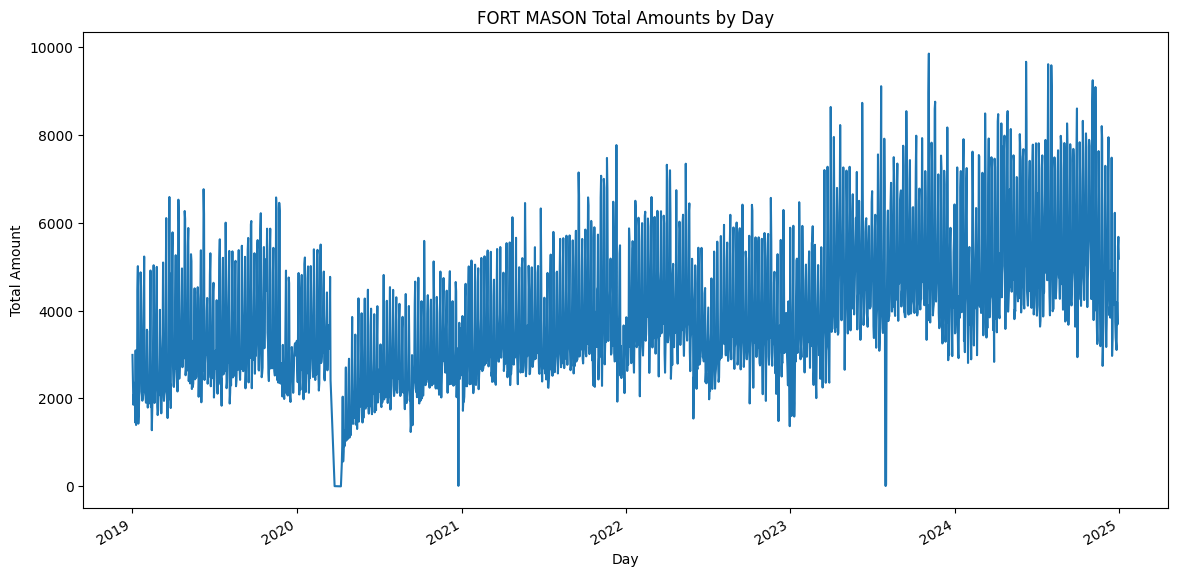

In [60]:
# Convert 'DOB' to datetime
fortMason5y_data['DOB'] = pd.to_datetime(fortMason5y_data['DOB'])

# Group the data by 'DOB' and sum the 'AMOUNT'
fm_daily_totals = fortMason5y_data.groupby('DOB')['AMOUNT'].sum()

# Plot the data
plt.figure(figsize=(14, 7))
fm_daily_totals.plot(kind='line')
plt.title('FORT MASON Total Amounts by Day')
plt.xlabel('Day')
plt.ylabel('Total Amount')
plt.show()

In [61]:
# Find the days with zero sales (or very low sales) - see if they are Christmas, New Year's Day, etc. - but maybe it's too much rain or too hot!?
sales_anomolies_max = 250

unusually_low_sales_days = fm_daily_totals[fm_daily_totals < sales_anomolies_max]
print('unusually_low_sales_days')
print(unusually_low_sales_days)

unusually_low_sales_days
DOB
2020-03-25     4.25
2020-04-08     0.00
2020-12-25    11.00
2023-07-31    40.00
2023-08-01     7.25
2023-08-02    42.00
Name: AMOUNT, dtype: float64


Now do Lake Merritt

In [62]:
lakeMerritt5ySalesURL = "https://www.dropbox.com/scl/fi/zcfrcc3mlhuapy2bqbyhc/LakeMerritt5yrNetSalesbyDay.csv?rlkey=7b0vk7k3frcwkoxg281tx4mpu&dl=1"
lakeMerritt5y_data = pd.read_csv(lakeMerritt5ySalesURL)
# Preview
print(lakeMerritt5y_data.head())


   LOCATION ID LOCATION NAME       DOB DAY OF WEEK              MSD  \
0            7  Lake Merritt  1/1/2019     Tuesday  COFFEE & NA BEV   
1            7  Lake Merritt  1/1/2019     Tuesday             FOOD   
2            7  Lake Merritt  1/1/2019     Tuesday           RETAIL   
3            7  Lake Merritt  1/1/2019     Tuesday             FOOD   
4            7  Lake Merritt  1/1/2019     Tuesday             FOOD   

                       SD   AMOUNT  COMP AMOUNT  PROMO AMOUNT  
0    Retail Coffee Drinks  1141.88         0.22             0  
1      Baked Goods-Pantry   125.50         0.00             0  
2           Retail Coffee   108.00         0.00             0  
3          Prepared Foods    72.00         0.00             0  
4  Retail Packaged-Pantry    51.50         0.00             0  


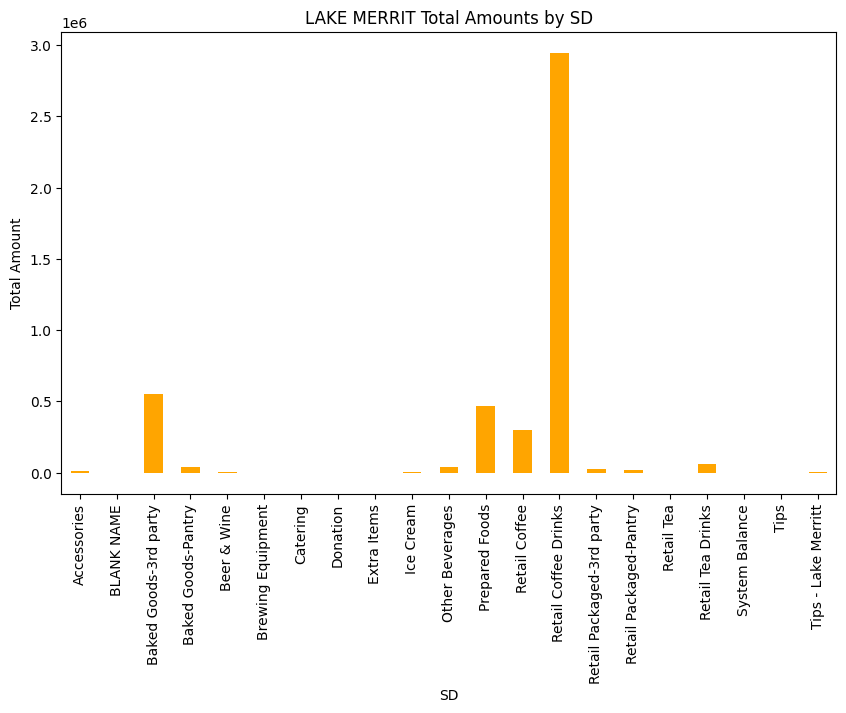

In [63]:
# Group the data by 'SD' and sum the 'AMOUNT'
lm_grouped_data = lakeMerritt5y_data.groupby('SD')['AMOUNT'].sum()

# Plot the data
plt.figure(figsize=(10, 6))
lm_grouped_data.plot(kind='bar', color='orange')
plt.title('LAKE MERRIT Total Amounts by SD')
plt.xlabel('SD')
plt.ylabel('Total Amount')
plt.show()

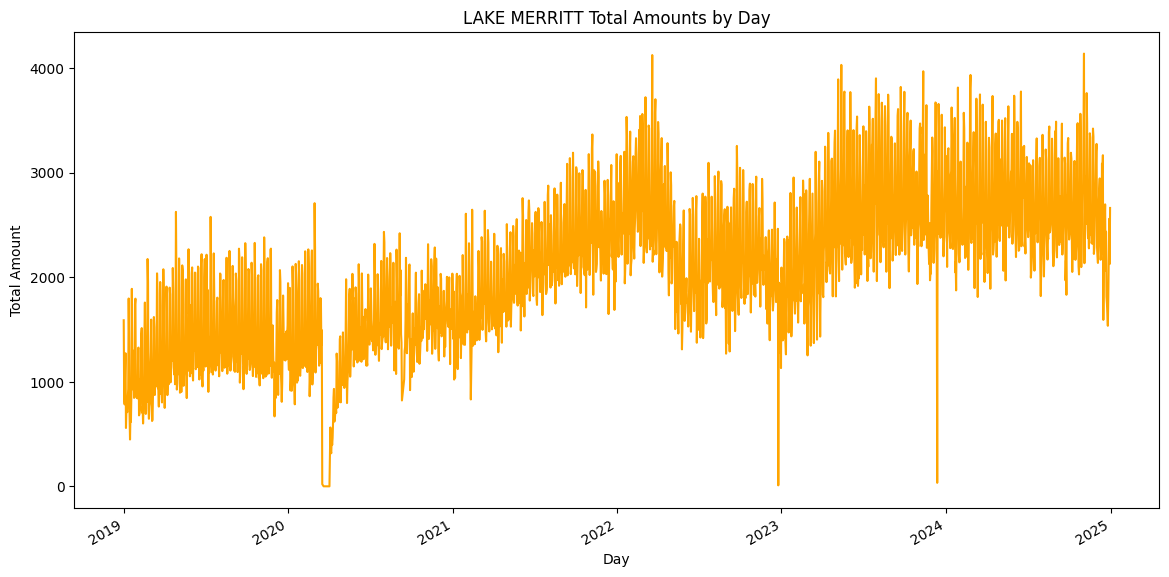

In [64]:
# Convert 'DOB' to datetime
lakeMerritt5y_data['DOB'] = pd.to_datetime(lakeMerritt5y_data['DOB'])

# Group the data by 'DOB' and sum the 'AMOUNT'
lm_daily_totals = lakeMerritt5y_data.groupby('DOB')['AMOUNT'].sum()

# Plot the data
plt.figure(figsize=(14, 7))
lm_daily_totals.plot(kind='line', color='orange')
plt.title('LAKE MERRITT Total Amounts by Day')
plt.xlabel('Day')
plt.ylabel('Total Amount')
plt.show()


In [65]:
unusually_low_sales_days = lm_daily_totals[lm_daily_totals < sales_anomolies_max]
print('unusually_low_sales_days')
print(unusually_low_sales_days)

unusually_low_sales_days
DOB
2020-03-17    20.5
2020-03-20     0.4
2020-04-02     0.0
2022-12-25     9.5
2023-12-13    33.5
Name: AMOUNT, dtype: float64


Finally, do Larkspur

In [66]:
larkspur5ySalesURL = "https://www.dropbox.com/scl/fi/n037thzcegug919e0ajqj/Larkspur5yrNetSalesbyDay.csv?rlkey=3pg7sv4fbur1tfo2ax7ebz70z&dl=1"
larkspur5y_data = pd.read_csv(larkspur5ySalesURL)
# Preview
print(larkspur5y_data.head())


   LOCATION ID LOCATION NAME       DOB DAY OF WEEK              MSD  \
0            4      Larkspur  1/1/2019     Tuesday  COFFEE & NA BEV   
1            4      Larkspur  1/1/2019     Tuesday             FOOD   
2            4      Larkspur  1/1/2019     Tuesday             FOOD   
3            4      Larkspur  1/1/2019     Tuesday             FOOD   
4            4      Larkspur  1/1/2019     Tuesday           RETAIL   

                       SD   AMOUNT  COMP AMOUNT  PROMO AMOUNT  
0    Retail Coffee Drinks  1612.96        35.14             0  
1      Baked Goods-Pantry   185.00         0.00             0  
2   Baked Goods-3rd party   175.00         0.00             0  
3  Retail Packaged-Pantry   144.75         0.00             0  
4           Retail Coffee   142.50         0.00             0  


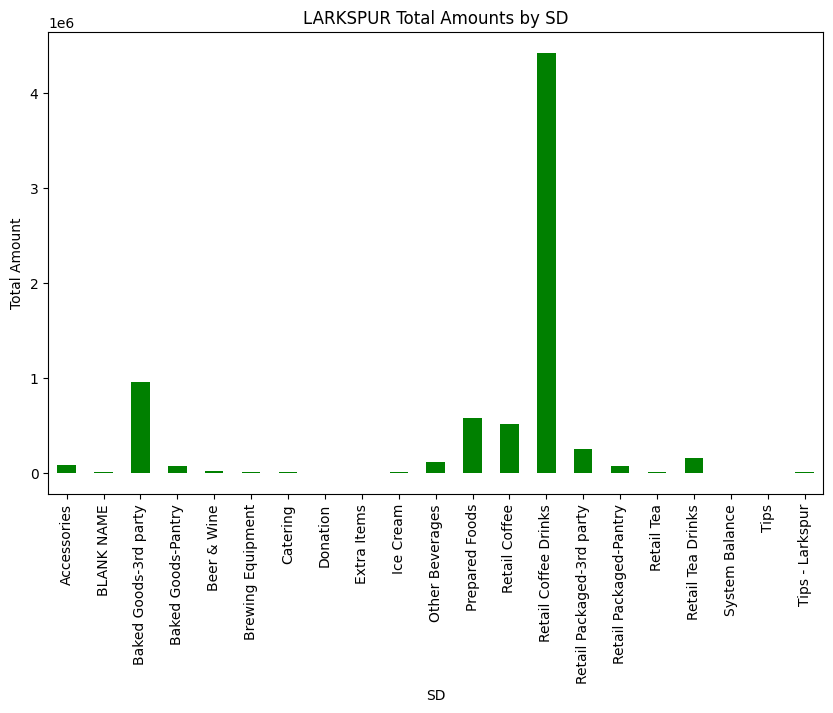

In [67]:
# Group the data by 'SD' and sum the 'AMOUNT'
ls_grouped_data = larkspur5y_data.groupby('SD')['AMOUNT'].sum()

# Plot the data
plt.figure(figsize=(10, 6))
ls_grouped_data.plot(kind='bar', color='green')
plt.title('LARKSPUR Total Amounts by SD')
plt.xlabel('SD')
plt.ylabel('Total Amount')
plt.show()

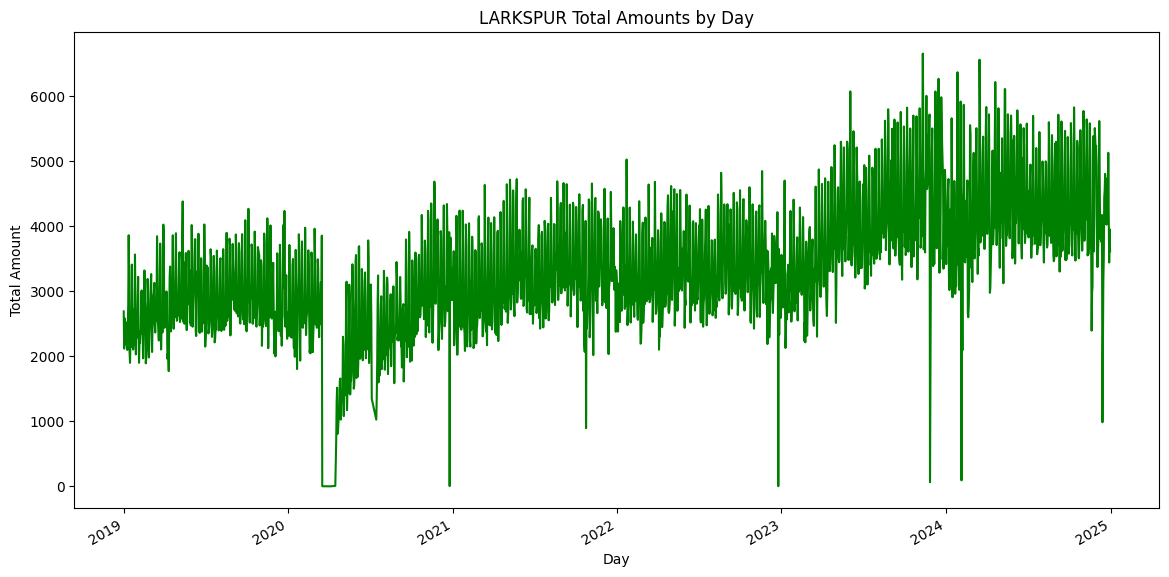

In [68]:
# Convert 'DOB' to datetime
larkspur5y_data['DOB'] = pd.to_datetime(larkspur5y_data['DOB'])

# Group the data by 'DOB' and sum the 'AMOUNT'
ls_daily_totals = larkspur5y_data.groupby('DOB')['AMOUNT'].sum()

# Plot the data
plt.figure(figsize=(14, 7))
ls_daily_totals.plot(kind='line', color='green')
plt.title('LARKSPUR Total Amounts by Day')
plt.xlabel('Day')
plt.ylabel('Total Amount')
plt.show()


In [69]:
unusually_low_sales_days = ls_daily_totals[ls_daily_totals < sales_anomolies_max]
print('unusually_low_sales_days')
print(unusually_low_sales_days)

unusually_low_sales_days
DOB
2020-03-17     4.00
2020-04-04     2.50
2020-04-15     9.25
2020-12-25     6.50
2022-12-25     4.75
2023-11-27    66.00
2024-02-05    94.00
Name: AMOUNT, dtype: float64


Merge the sales date for all 3 stores into one graph

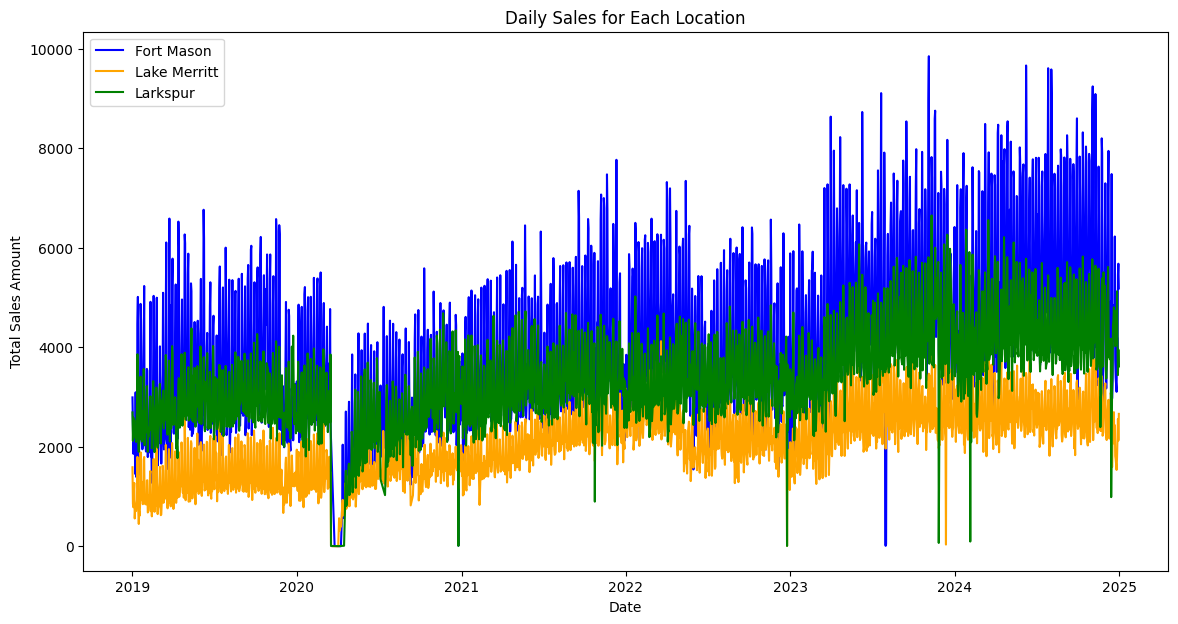

In [71]:
# Plot the daily sales for each location in one graph
plt.figure(figsize=(14, 7))

# Plot Fort Mason daily sales
plt.plot(fm_daily_totals.index, fm_daily_totals.values, label='Fort Mason', color='blue')

# Plot Lake Merritt daily sales
plt.plot(lm_daily_totals.index, lm_daily_totals.values, label='Lake Merritt', color='orange')

# Plot Larkspur daily sales
plt.plot(ls_daily_totals.index, ls_daily_totals.values, label='Larkspur', color='green')

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Total Sales Amount')
plt.title('Daily Sales for Each Location')
plt.legend()

# Show the plot
plt.show()

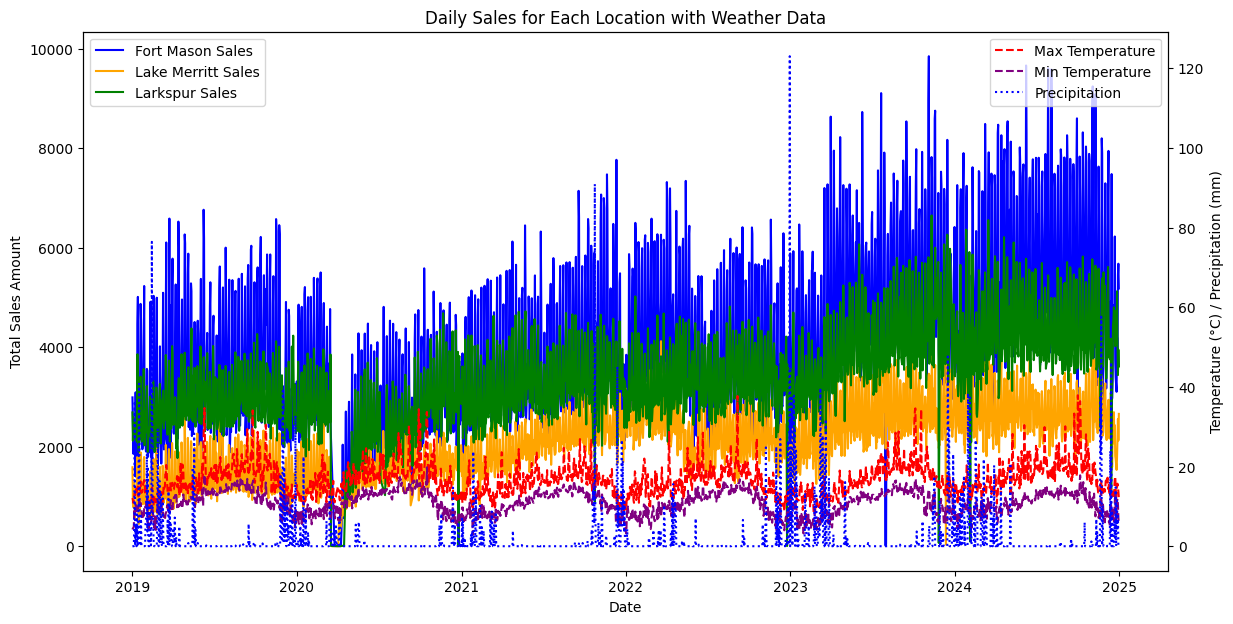

In [75]:
# Plot the daily sales for each location in one graph
fig, ax1 = plt.subplots(figsize=(14, 7))

# Plot Fort Mason daily sales
ax1.plot(fm_daily_totals.index, fm_daily_totals.values, label='Fort Mason Sales', color='blue')

# Plot Lake Merritt daily sales
ax1.plot(lm_daily_totals.index, lm_daily_totals.values, label='Lake Merritt Sales', color='orange')

# Plot Larkspur daily sales
ax1.plot(ls_daily_totals.index, ls_daily_totals.values, label='Larkspur Sales', color='green')

# Add labels and title for sales
ax1.set_xlabel('Date')
ax1.set_ylabel('Total Sales Amount')
ax1.set_title('Daily Sales for Each Location with Weather Data')
ax1.legend(loc='upper left')

# Create a secondary y-axis for weather data
ax2 = ax1.twinx()

# Plot Max Temperature
ax2.plot(weather_data['date'], weather_data['temp_max'], label='Max Temperature', color='red', linestyle='--')

# Plot Min Temperature
ax2.plot(weather_data['date'], weather_data['temp_min'], label='Min Temperature', color='purple', linestyle='--')

# Plot Precipitation
ax2.plot(weather_data['date'], weather_data['precipitation'], label='Precipitation', color='blue', linestyle=':')

# Add labels for weather data
ax2.set_ylabel('Temperature (°C) / Precipitation (mm)')
ax2.legend(loc='upper right')

# Show the plot
plt.show()